In [1]:
import json
import numpy as np
import os

In [2]:
texts = []
labels = []
#실행 파일과 같은 폴더에 파일들이 존재해야 합니다.
for i in range(1, 200):
    file_name = f'기술_과학_{i}.json'  
    
    if os.path.exists(file_name):  # 파일이 존재하는 경우에만 처리
        with open(file_name, 'r', encoding='utf-8') as file:
            data = json.load(file)
        
        for conversation in data["dataset"].get("conversations", []):
            for utterance in conversation.get("utterances", []):
                text = utterance.get("utterance_text", "")
                evaluation = utterance.get("utterance_evaluation", [])
                if evaluation:  # 평가 대상이 아닌 문장을 제외
                    texts.append(text)
                    labels.append(evaluation)

In [3]:
#토큰화 코드: 라이브러리 사용
import konlpy 
from konlpy.tag import Okt, Hannanum, Kkma 

okt = Okt()
tokenized_texts = []

for i in range(len(texts)):
    tokenized_texts.append(okt.morphs(texts[i]))
flattened_list = [item for sublist in tokenized_texts for item in sublist]    

In [4]:
#word2vec 과정
_word_to_id = {}
_id_to_word = {}




def preprocess(words): #앞에서 토큰화를 해서 적절히 바꿨습니다. 
    for word in words:
        if word not in _word_to_id:
            new_id = len(_word_to_id)
            _word_to_id[word] = new_id
            _id_to_word[new_id] = word
    corpus = np.array([_word_to_id[w] for w in words])
    return corpus, _word_to_id, _id_to_word

In [5]:
attribute_labels = {
    'linguistic_acceptability': [],
    'consistency': [],
    'interestingness': [],
    'unbias': [],
    'harmlessness': [],
    'no_hallucination': [],
    'understandability': [],
    'sensibleness': [],
    'specificity': []
}

# 속성별 레이블 추출
for i in range(len(labels)):
    # 현재 대화에 대한 속성값 초기화
    attribute_values = {key: 0 for key in attribute_labels.keys()}

    for j in range(len(labels[i])):
        for key in attribute_labels.keys():
            if labels[i][j].get(key) == 'yes':
                attribute_values[key] += 1

    # 각 속성별로 모든 발화에서 'yes'인 경우만 1, 아니면 0
    for key in attribute_labels.keys():
        if attribute_values[key] == len(labels[i]):
            attribute_labels[key].append(1)
        else:
            attribute_labels[key].append(0)

In [6]:
corpus, word_to_id, id_to_word = preprocess(flattened_list)
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

In [7]:
import sys
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from rnnlm import Rnnlm

| 에폭 1 |  반복 1 / 76 | 시간 0[s] | 퍼플렉서티 7268.13
| 에폭 1 |  반복 21 / 76 | 시간 2[s] | 퍼플렉서티 3220.01
| 에폭 1 |  반복 41 / 76 | 시간 4[s] | 퍼플렉서티 1418.43
| 에폭 1 |  반복 61 / 76 | 시간 6[s] | 퍼플렉서티 1100.86
| 에폭 2 |  반복 1 / 76 | 시간 7[s] | 퍼플렉서티 936.08
| 에폭 2 |  반복 21 / 76 | 시간 9[s] | 퍼플렉서티 752.03
| 에폭 2 |  반복 41 / 76 | 시간 11[s] | 퍼플렉서티 673.26
| 에폭 2 |  반복 61 / 76 | 시간 13[s] | 퍼플렉서티 500.09
| 에폭 3 |  반복 1 / 76 | 시간 15[s] | 퍼플렉서티 450.76
| 에폭 3 |  반복 21 / 76 | 시간 17[s] | 퍼플렉서티 394.82
| 에폭 3 |  반복 41 / 76 | 시간 19[s] | 퍼플렉서티 383.58
| 에폭 3 |  반복 61 / 76 | 시간 21[s] | 퍼플렉서티 294.65
| 에폭 4 |  반복 1 / 76 | 시간 23[s] | 퍼플렉서티 280.11
| 에폭 4 |  반복 21 / 76 | 시간 25[s] | 퍼플렉서티 249.88
| 에폭 4 |  반복 41 / 76 | 시간 27[s] | 퍼플렉서티 257.62
| 에폭 4 |  반복 61 / 76 | 시간 29[s] | 퍼플렉서티 204.61


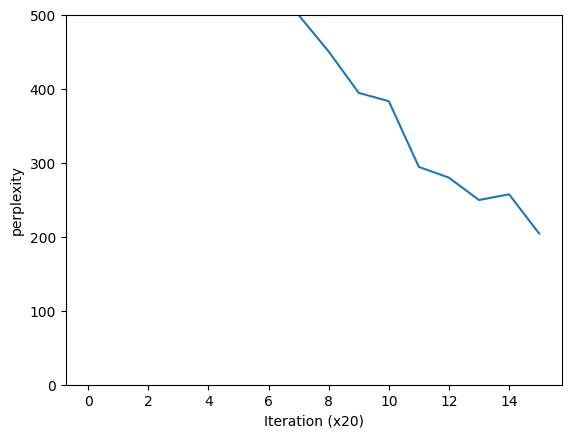

In [8]:
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

In [9]:
model.loss_layer.grads

[]

In [10]:
model.lstm_layer.params

[array([[-0.09931683,  0.04146024, -0.02054795, ...,  0.07725614,
         -0.1907632 , -0.29998353],
        [-0.03822083,  0.08858948,  0.02639859, ..., -0.17684765,
         -0.00122294,  0.02451525],
        [-0.11336339,  0.06553911, -0.13072345, ...,  0.2199759 ,
          0.20362948,  0.12911136],
        ...,
        [ 0.00488837, -0.22050603, -0.09534346, ...,  0.06381095,
          0.25099275,  0.09905355],
        [ 0.04672311, -0.10045799, -0.24989611, ..., -0.09784223,
         -0.06174868,  0.07583202],
        [ 0.07837753,  0.1717118 , -0.08593751, ..., -0.1096727 ,
         -0.05596013,  0.01330206]], dtype=float32),
 array([[ 0.06049323,  0.03127905,  0.02295263, ...,  0.33019066,
          0.1603423 , -0.1276763 ],
        [-0.2143586 , -0.05808518, -0.08280256, ...,  0.11163363,
         -0.07710348,  0.13240044],
        [ 0.25880504, -0.07603198,  0.2847407 , ..., -0.09046824,
         -0.11159421, -0.03924829],
        ...,
        [ 0.02299385,  0.09048294,  0.0

In [11]:
test_texts = []
test_labels = []

for i in range(1, 100):
    file_name = f'기술_과학_{i}.json'  
    
    if os.path.exists(file_name):  # 파일이 존재하는 경우에만 처리
        with open(file_name, 'r', encoding='utf-8') as file:
            data = json.load(file)
        
        for conversation in data["dataset"].get("conversations", []):
            for utterance in conversation.get("utterances", []):
                text = utterance.get("utterance_text", "")
                evaluation = utterance.get("utterance_evaluation", [])
                if evaluation:  # 평가 대상이 아닌 문장을 제외
                    test_texts.append(text)
                    test_labels.append(evaluation)

test_tokenized_texts = []
for i in range(len(texts)):
    test_tokenized_texts.append(okt.morphs(texts[i]))
test_flattened_list = [item for sublist in test_tokenized_texts for item in sublist] 

test_attribute_labels = {
    'linguistic_acceptability': [],
    'consistency': [],
    'interestingness': [],
    'unbias': [],
    'harmlessness': [],
    'no_hallucination': [],
    'understandability': [],
    'sensibleness': [],
    'specificity': []
}

# 속성별 레이블 추출
for i in range(len(labels)):
    # 현재 대화에 대한 속성값 초기화
    attribute_values = {key: 0 for key in test_attribute_labels.keys()}

    for j in range(len(labels[i])):
        for key in test_attribute_labels.keys():
            if labels[i][j].get(key) == 'yes':
                attribute_values[key] += 1

    # 각 속성별로 모든 발화에서 'yes'인 경우만 1, 아니면 0
    for key in test_attribute_labels.keys():
        if attribute_values[key] == len(labels[i]):
            test_attribute_labels[key].append(1)
        else:
            test_attribute_labels[key].append(0)

test_corpus, test_word_to_id, test_id_to_word = preprocess(test_flattened_list)
vocab_size = len(test_word_to_id)
xs = test_corpus[:-1]
ts = test_corpus[1:]

In [12]:
loss = trainer.fitv2(xs, ts, max_epoch, batch_size, time_size, max_grad)

| 에폭 5 |  반복 1 / 76 | 시간 0[s] | 퍼플렉서티 198.49
| 에폭 5 |  반복 21 / 76 | 시간 2[s] | 퍼플렉서티 174.92
| 에폭 5 |  반복 41 / 76 | 시간 4[s] | 퍼플렉서티 173.91
| 에폭 5 |  반복 61 / 76 | 시간 6[s] | 퍼플렉서티 138.59
| 에폭 6 |  반복 1 / 76 | 시간 7[s] | 퍼플렉서티 146.73
| 에폭 6 |  반복 21 / 76 | 시간 9[s] | 퍼플렉서티 126.81
| 에폭 6 |  반복 41 / 76 | 시간 11[s] | 퍼플렉서티 131.45
| 에폭 6 |  반복 61 / 76 | 시간 13[s] | 퍼플렉서티 105.06
| 에폭 7 |  반복 1 / 76 | 시간 15[s] | 퍼플렉서티 103.85
| 에폭 7 |  반복 21 / 76 | 시간 17[s] | 퍼플렉서티 96.84
| 에폭 7 |  반복 41 / 76 | 시간 19[s] | 퍼플렉서티 100.11
| 에폭 7 |  반복 61 / 76 | 시간 21[s] | 퍼플렉서티 82.06
| 에폭 8 |  반복 1 / 76 | 시간 22[s] | 퍼플렉서티 78.40
| 에폭 8 |  반복 21 / 76 | 시간 24[s] | 퍼플렉서티 74.34
| 에폭 8 |  반복 41 / 76 | 시간 26[s] | 퍼플렉서티 75.66
| 에폭 8 |  반복 61 / 76 | 시간 28[s] | 퍼플렉서티 63.94


In [13]:
len(loss)

304

In [14]:
len(test_corpus)

53688

In [15]:
len(test_texts)

734

In [16]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from better_rnnlm import BetterRnnlm

In [17]:
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

In [18]:
model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

In [ ]:
#LSTM 개선 버전 사용 코드
best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, test_corpus)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, test_corpus)
print('테스트 퍼플렉서티: ', ppl_test)

| 에폭 2 |  반복 1 / 76 | 시간 1[s] | 퍼플렉서티 1241.72
| 에폭 2 |  반복 21 / 76 | 시간 22[s] | 퍼플렉서티 1154.60
| 에폭 2 |  반복 41 / 76 | 시간 43[s] | 퍼플렉서티 1031.42
| 에폭 2 |  반복 61 / 76 | 시간 64[s] | 퍼플렉서티 755.96
퍼플렉서티 평가 중 ...
999 / 10001
검증 퍼플렉서티:  538.0110431307811
--------------------------------------------------
| 에폭 3 |  반복 1 / 76 | 시간 1[s] | 퍼플렉서티 572.60
| 에폭 3 |  반복 21 / 76 | 시간 22[s] | 퍼플렉서티 565.83
| 에폭 3 |  반복 41 / 76 | 시간 44[s] | 퍼플렉서티 530.44
| 에폭 3 |  반복 61 / 76 | 시간 66[s] | 퍼플렉서티 410.61
퍼플렉서티 평가 중 ...
999 / 10001
검증 퍼플렉서티:  334.4673155035835
--------------------------------------------------
| 에폭 4 |  반복 1 / 76 | 시간 1[s] | 퍼플렉서티 362.44
| 에폭 4 |  반복 21 / 76 | 시간 22[s] | 퍼플렉서티 362.63
| 에폭 4 |  반복 41 / 76 | 시간 44[s] | 퍼플렉서티 349.75
| 에폭 4 |  반복 61 / 76 | 시간 66[s] | 퍼플렉서티 265.62
퍼플렉서티 평가 중 ...
999 / 10001
검증 퍼플렉서티:  211.00238477985334
--------------------------------------------------
| 에폭 5 |  반복 1 / 76 | 시간 1[s] | 퍼플렉서티 249.23
| 에폭 5 |  반복 21 / 76 | 시간 22[s] | 퍼플렉서티 247.10
| 에폭 5 |  반복 41 / 76 | 시간